## Pro Kabaddi Hackathon

## Objective
To predict the following for current season -Season 7, 2019
#### Team
- winner of the tournament
- top team in the points table after the completion of the league matches
- team with the highest points for successful raids
- team with the highest points for successful tackles
- team with the highest super-performance total
#### Players
- player with the highest SUCCESSFUL RAID percentage
- player with the highest SUCCESSFUL TACKLE percentage

#### Data Files Used -
1. Teams_cur_seasons_matches.csv - current seasons completed match details - (Manually collected)
2. Teams_cur_seasons_matches_upcoming.csv - current seasons upcoming match details - (Manually collected)
3. Teams_prev_seasons_matches.csv - scraped -  previous seasons completed match details - (Manually collected)
4. Teams_cur_seasons_allpoints.csv - Current seasons team points scraped - through scripts (source https://www.prokabaddi.com/)
5. Teams_prev_seasons_allpoints.csv - Previous seasons team points scraped through scripts

## Prediction Logic
### Team - Winners/ Top Ranks
- For each season, all match details (teams, winners, match scores, match points, home/away ) and overall, attack and defence points for the season is collected and tabulated for each match
- The team rank pregression with each match is calculated
- The target variable used is 'Team 1 Winner?'
- All completed match data is split into train / test sets.
- Scaled data is used to build a classification model to predict the probability of Team 1 winning
- Using the tuned, final model, the upcoming matches are predicted.
- The team standing ranks are calculated
- the top 3,4,5,6 teams are assigned for elimination matches
- the winners of elimination matches are assigned for semi finals with top 1 and 2 teams
- the finalists are assigned to final match and winner is predicted.
- after each match the team points and ranks are calculated

#### import Libraries

In [1]:
from datetime import datetime
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', None)

#### Read in Match Details

In [4]:
df_prev_matches = pd.read_csv('Teams_prev_seasons_matches.csv')
df_curr_matches = pd.read_csv('Teams_cur_seasons_matches.csv')
df_curr_u_matches = pd.read_csv('Teams_cur_seasons_matches_upcoming.csv')

In [5]:
df_matches = pd.concat([df_prev_matches, df_curr_matches])
df_matches=pd.concat([df_matches,df_curr_u_matches])

In [6]:
df_matches.head(3)

,Season,Date,Match Type,Match No,Status,Zone,Team1,Team 1 Points,Team 2 Points,Team2,Winner,Played at home of?,Stadium
0,Season 1,"SATURDAY, 26 JULY",NaN,1,COMPLETED,NaN,U Mumba,45.0,31.0,Jaipur Pink Panthers,U Mumba,U Mumba,"DOME@NSCI SVP STADIUM, MUMBAI"
1,Season 1,"SATURDAY, 26 JULY",NaN,2,COMPLETED,NaN,Dabang Delhi K.C.,28.0,47.0,Bengaluru Bulls,Bengaluru Bulls,U Mumba,"DOME@NSCI SVP STADIUM, MUMBAI"
2,Season 1,"SUNDAY, 27 JULY",NaN,3,COMPLETED,NaN,Bengaluru Bulls,40.0,37.0,Puneri Paltan,Bengaluru Bulls,U Mumba,"DOME@NSCI SVP STADIUM, MUMBAI"


#### Read in Team Points

In [7]:
df_prev_points = pd.read_csv('Teams_prev_seasons_allpoints.csv')
df_curr_points = pd.read_csv('Teams_cur_seasons_allpoints.csv')

df_points = pd.concat([df_prev_points, df_curr_points])

In [8]:
df_points.head(3)

,Season,All-outs Conceded_Rank,Name,Matches Played,All-outs Conceded,All-outs Inflicted_Rank,All-outs Inflicted,Avg points Scored_Rank,Avg points Scored,Avg Raid Points_Rank,Avg Raid Points,Avg Tackle Points_Rank,Avg Tackle Points,Do-Or-Die Raid Points_Rank,Do-Or-Die Raid Points,Raid Points_Rank,Raid Points,Successful Raids_Rank,Successful Raids,Successful Tackles_Rank,Successful Tackles,Super Raid_Rank,Super Raid,Super Tackles_Rank,Super Tackles,Tackle Points_Rank,Tackle Points,Total Points Conceded_Rank,Total Points Conceded,Total Points Scored_Rank,Total Points Scored
0,Season 1,1,Puneri Paltan,14,26,7,12,8,26.85,7,19.21,7,7.64,2,48,8,269,8,204,8,93,3,11,3,14,7,107,1,536,8,405
1,Season 1,2,Bengal Warriors,14,25,8,11,5,28.92,5,20.21,6,8.71,8,30,7,283,7,213,6,106,3,11,2,16,6,122,2,515,7,430
2,Season 1,3,Dabang Delhi K.C.,14,23,5,18,4,29.92,4,20.36,4,9.57,6,31,6,285,5,246,4,124,8,5,6,10,5,134,7,471,6,456


### Data Preparation

In [9]:
matches_cols = list(df_matches.columns)
matches_cols = [col.replace(' ', '_') for col in matches_cols]
matches_cols = [col.replace('?', '') for col in matches_cols]
df_matches.columns = matches_cols

#### Set Date Fields

In [10]:
def get_year(x):
    season_years = {'Season 1': '2014', 'Season 2': '2015', 
                    'Season 3': '2016', 'Season 4': '2016', 
                    'Season 5': '2017', 'Season 6': '2018', 'Season 7': '2019'}
    return season_years[x]

def set_date_fields(df_in):
    df_in['Weekend'] = df_in.Date.str.split(',', 2, expand=True)[0].\
                                                apply(lambda x: 1 if x in ['SATURDAY', 'SUNDAY'] else 0)
    df_in.Date = df_in.Date.str.strip()
    df_in.Date = pd.to_datetime(df_in.Date.str.split(',', 2, expand=True)[1].str.strip() + \
                                     ' ' + \
                                     df_in.Season.map(get_year), format='%d %B %Y')
    df_in.Date = pd.to_datetime(df_in.Date)
    return df_in

In [11]:
df_matches=set_date_fields(df_matches)

#### Set Match Number for all matches

In [12]:
df_matches=df_matches.sort_values(by=['Season','Date']).reset_index()
df_matches['Match_Number']=df_matches.index+1

#### Encode qualifier / final matches

In [13]:
def map_match_nos(df_in):
    df_in['Match_No']=df_in['Match_No'].fillna(0)
    df_in['Match_No'] = df_in['Match_No'].replace({'FINAL ': 'F','ELIMINATOR 1 ': 'E1', 'ELIMINATOR 2 ': 'E2', 
                                                   'ELIMINATOR 3 ': 'E3',
                                                   'Semi Final1': 'SF1', 'Semi Final2': 'SF2',
                                                   '3RD PLACE PLAYOFF ': '3rd', '3/4 PLACE ': '3rd'})
    df_in['Match_Type'] = df_in['Match_No'].apply(lambda x: 'League' if str(x).isnumeric() else x)
    return df_in

In [14]:
df_matches=map_match_nos(df_matches)

#### Add new columns used for derived variables

In [15]:
new_columns=['Team1_Winner','Team1_match_points','Team2_match_points','Team1_points_before','Team2_points_before',
            'Team1_points_after','Team2_points_after','Team1_Home', 'Team2_Home']

for col in new_columns:
    df_matches[col]=0
df_matches[['Team_1_Points','Team_2_Points']]=df_matches[['Team_1_Points','Team_2_Points']].fillna(0)

In [16]:
df_matches.head(1)

,index,Season,Date,Match_Type,Match_No,Status,Zone,Team1,Team_1_Points,Team_2_Points,Team2,Winner,Played_at_home_of,Stadium,Weekend,Match_Number,Team1_Winner,Team1_match_points,Team2_match_points,Team1_points_before,Team2_points_before,Team1_points_after,Team2_points_after,Team1_Home,Team2_Home
0,0,Season 1,2014-07-26,League,1,COMPLETED,NaN,U Mumba,45.0,31.0,Jaipur Pink Panthers,U Mumba,U Mumba,"DOME@NSCI SVP STADIUM, MUMBAI",1,1,0,0,0,0,0,0,0,0,0


#### split final matches
- The final matches do not have team details.
- following code sets teamwise season point details and match points

In [17]:
df_finals=df_matches[df_matches.Team1.isnull()]
df_matches=df_matches[df_matches.Team1.notnull()]

### Set team points season wise

In [18]:
points_cols = list(df_points.columns)
points_cols = [col.replace(' ', '_') for col in points_cols]
points_cols = [col.replace('-', '_') for col in points_cols]
df_points.columns = points_cols
points_cols.remove('Season')
points_cols.remove('Name')

team1_points_cols = ['Team1_' + col for col in points_cols]
team2_points_cols = ['Team2_' + col for col in points_cols]

#### Function to set season points
- reused later for final matches when teams are identified

In [19]:
def get_season_points(x):
    team1_points = df_points[(df_points.Season == x.Season) & \
                             (df_points.Name == x.Team1)][points_cols].iloc[0]
    team2_points = df_points[(df_points.Season == x.Season) & \
                             (df_points.Name == x.Team2)][points_cols].iloc[0]

    team1_points.index = team1_points_cols
    team2_points.index = team2_points_cols

    row = pd.concat([pd.Series(x), 
                     team1_points, 
                     team2_points])
    if row['Played_at_home_of'] == row['Team1']:
        row['Team1_Home'] = 1

    if row['Played_at_home_of'] == row['Team2']:
        row['Team2_Home'] = 1

    if row['Winner'] == row['Team1']:
        row['Team1_Winner'] = 1
    return row

#### Match Point Calculation

In [20]:
def caclulate_match_points(x):
    score_diff= int(x['Team_1_Points']) - int(x['Team_2_Points'])
    if x['Winner'] != 'None':
        if x['Winner'] == x['Team1']:
            x['Team1_match_points'] = 5
            if score_diff !=0 and score_diff <= 7:
                x['Team2_match_points'] = 1
        elif x['Winner'] == x['Team2']:
            x['Team2_match_points'] = 5
            if score_diff !=0 and -1*score_diff <= 7:
                x['Team1_match_points'] = 1
        elif x['Winner'] == 'Tied':
            x['Team1_match_points'] = 3
            x['Team2_match_points'] = 3    
    return x

#### function to create standing points table as the matches pregress
- for each season, the function creates the match points after each match team wise
- columns - match number, team1, team2,team3...
- rows consist of cumulative sum of match points, one row for match

#### set_team_standings_for_matches 
- calculates the before and after points for team1 and team2 for each match

In [21]:
def create_season_standing_points(df_season_in):
    #Get team list
    teams=df_season_in.Team1.unique().tolist()
    
    # Get all Team1 points 
    df_season_standings1 = df_season_in[['Match_Number','Team1','Team1_match_points']]
    df_season_standings1=df_season_standings1.rename(columns={'Team1':'Team','Team1_match_points':'Points'})
    
    #Get all Team2 points
    df_season_standings2 = df_season_in[['Match_Number','Team2','Team2_match_points']]
    df_season_standings2=df_season_standings2.rename(columns={'Team2':'Team','Team2_match_points':'Points'})
    
    #Concatenate and reshape teh dataframe to have teams, Match_Number as columns, points as rows
    df_season_standings=pd.concat([df_season_standings1,df_season_standings2],axis=0)
    df_season_standings_points=df_season_standings.pivot(index='Match_Number', columns='Team', values='Points')
    
    #Add new fields for Match_Number
    df_season_standings_points['Match_Number'] = df_season_standings_points.index   
    
    # Each row will contain NANs for teams that don't play, set them to 0
    df_season_standings_points=df_season_standings_points.fillna(0)
    
    # get the cumulative sum for match after match
    df_season_standings_points[teams]= df_season_standings_points[teams].cumsum()
    return df_season_standings_points

def create_team_standing_points(df_in):
    ## for each season, create match standings points
    standings=pd.DataFrame()
    for season in df_in.Season.unique().tolist():
        df=df_in.loc[df_in['Season']==season]
        df_points_season= create_season_standing_points(df)
        df_points_season['Season']=season
        standings=pd.concat([standings,df_points_season],axis=0)
    return standings

def set_team_standings_for_matches(x):
    x['Team1_points_after']=standing_points.loc[(standing_points['Match_Number']==x.Match_Number),x.Team1].iloc[0]
    x['Team1_points_before']=x['Team1_points_after']-x['Team1_match_points']
    x['Team2_points_after']=standing_points.loc[(standing_points['Match_Number']==x.Match_Number),x.Team2].iloc[0]
    x['Team2_points_before']=x['Team2_points_after']-x['Team2_match_points']
    return x

def set_team_standing_points (df_in):
    global standing_points
    ## Create seasonwise, match points table for all teams
    standing_points=create_team_standing_points(df_in)
    ##  for each match calculate before and after standings points
    df_in=df_in.apply(set_team_standings_for_matches, axis=1)
    return df_in

#### Set all points for each match

In [22]:
match_rows=[]
for rownum in range(df_matches.shape[0]):
    row = get_season_points(df_matches.iloc[rownum]) 
    match_rows.append(row)
df_matches_points = pd.DataFrame(data=match_rows) 

df_matches_points.Winner=df_matches_points.Winner.fillna('None')
df_matches_points=df_matches_points.apply(caclulate_match_points, axis=1)
df_matches_points=set_team_standing_points(df_matches_points)

In [23]:
df_matches_points.shape

(647, 83)

#### Fields for the model
- Remove all match result fields 

In [24]:
df_matches_points=df_matches_points.drop(['Zone', 'Stadium'],axis=1)
boolean_fields = [col for col in df_matches_points if 
               df_matches_points[col].value_counts().index.isin([0,1]).all()]
# boolean_fields
numeric_fields=df_matches_points.select_dtypes(exclude=['object']).columns
numeric_fields = list(set(numeric_fields)-set(boolean_fields))
numeric_fields = list(set(numeric_fields)-set(['Team_1_Points','Team1_match_points','Team1_points_after','Team1_Matches_Played',
                                               'Team_2_Points','Team2_match_points','Team2_points_after','Team2_Matches_Played',
                                               'Date', 'index','Match_Number']))

#### Remove upcoming Match Rows

In [25]:
df_matches_upcoming=df_matches_points.loc[df_matches_points.Status=='UPCOMING']
df_matches_points=df_matches_points.loc[df_matches_points.Status != 'UPCOMING']

#### Check for nulls

In [26]:
def print_nulls(df_in):
    nulls = pd.DataFrame(df_in.isna().mean().round(4)*100).reset_index()
    nulls = nulls[nulls[0]>0].sort_values(by=[0],ascending=False)
    nulls= nulls.rename(columns={nulls.columns[1]:'%ge'})
    if nulls.shape[0]>0: print(nulls)
print_nulls(df_matches_points)

    index   %ge
5  Status  0.16


Status field not included in the model! so ok

##### Save columns for future use

In [27]:
y = df_matches_points.Team1_Winner
input_cols_to_model=boolean_fields + numeric_fields
input_cols_to_model.remove('Team1_Winner')
cols_to_scale=numeric_fields

In [28]:
X = df_matches_points[input_cols_to_model]

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, test_size=0.20, random_state=17)

In [30]:
columns_to_include=X_train.columns
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_train[cols_to_scale]=scaler.fit_transform(X_train[cols_to_scale])
X_test[cols_to_scale]=scaler.transform(X_test[cols_to_scale]) 

#### function to plot model metrics 

In [31]:
def find_ideal_cutoff():
    df_cutoff = pd.DataFrame(columns = ['cutoff','accuracy','sensitivity','specificity'])
    for cutoff in np.arange(0.0, 1.0, 0.05):
        cutoff = round(cutoff, 2)
        accuracy, sensitivity, specificity = validate_model(X_train,y_train,cutoff)
        df_cutoff.loc[cutoff] = [cutoff, accuracy, sensitivity, specificity]
    df_cutoff.plot.line(x='cutoff', y=['accuracy','sensitivity','specificity'], grid=True)
    plt.grid(b=True, which='minor', linestyle='-')
    plt.xticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    plt.show()

 #### Validate model on Train and test

In [32]:
def validate_model( X, y,cutoff,print_flag=False):
    
    y_pred = round(logmodel.predict(X), 6)

    df_result = pd.DataFrame()
    df_result['Won'] = y
    df_result['Predicted Probability'] = y_pred
    df_result['Win_Pred'] = y_pred.apply(lambda x: 1 if x > cutoff else 0)

    confusion = metrics.confusion_matrix(df_result.Won, df_result.Win_Pred)
    accuracy = round(metrics.accuracy_score(df_result.Won, df_result.Win_Pred), 6)
    
    TP = confusion[1,1] # true positive 
    TN = confusion[0,0] # true negatives
    FP = confusion[0,1] # false positives
    FN = confusion[1,0] # false negatives

    sensitivity = round(TP / float(TP+FN), 6)
    specificity = round(TN / float(TN+FP), 6)
    if print_flag :
        print('Accuracy : ' ,accuracy )
        print('Sensitivity : ' ,sensitivity)
        print('Specificity : ' ,specificity) 
    return accuracy,sensitivity,specificity

#### Functions to automate model tuning
-Recusively features with high p-value and/ or VIF are droped till the all the features have P Values and VIFs below acceptable limits

In [33]:
def model(print_flag=False):
    global logmodel
    logmodel = sm.GLM(y_train, X_train, family=sm.families.Binomial()).fit()
    if print_flag:
        print(logmodel.summary())
    return logmodel

def build_models():
    global X_train, X_test
    global y_train_pred, y_test_pred
    cols = list(X_train.columns)
    logmodel = model()
    end_reached = False
    for col in cols:
        highest_p_value = float(logmodel.summary2().tables[1]['P>|z|'].sort_values(ascending=False).head(1))
        field_with_highest_p_value = logmodel.summary2().tables[1]['P>|z|'].sort_values(ascending=False).head(1).index[0]
        if highest_p_value < 0.05:
            end_reached, field_with_highest_p_value = findmodelwithbestVIF()
            if end_reached:
                logmodel = model(print_flag=True)
                performVIFanalysis(print_flag=True)
                return logmodel
            else:
                X_train.pop(field_with_highest_p_value)
                print ('Dropping', field_with_highest_p_value, 'because it has highest p-value')
                logmodel = model()                        
        else:
            X_train.pop(field_with_highest_p_value)
            print ('Dropping', field_with_highest_p_value, 'because it has highest p-value')
            logmodel = model()        

def findmodelwithbestVIF():
    cols = list(X_train.columns)
    end_reached = False
    for col in cols:
        vif = performVIFanalysis()
        highest_VIF = vif[vif.VIF == vif.VIF.max()].VIF.values[0]
        field_with_highest_VIF = vif[vif.VIF == vif.VIF.max()].Feature.values[0]
        if highest_VIF < 5:
            modelwithbestVIF = model()
            highest_p_value = float(modelwithbestVIF.summary2().tables[1]['P>|z|'].\
                                    sort_values(ascending=False).head(1))
            field_with_highest_p_value = modelwithbestVIF.summary2().tables[1]['P>|z|'].\
                                         sort_values(ascending=False).head(1).index[0]
            if highest_p_value < 0.05:
                end_reached = True
            return end_reached, field_with_highest_p_value
        else:
            X_train.pop(field_with_highest_VIF)
            print ('Dropping', field_with_highest_VIF, 'because it has highest VIF')
            logmodel = model()
    
# create a dataframe that will contain the names of all the feature variables and their respective VIFs
def performVIFanalysis(print_flag=False):
    vif = pd.DataFrame()
    vif['Feature'] = X_train.columns
    vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    if print_flag:
        print(vif)
    return vif    

In [34]:
logmodel = build_models()

Dropping Team2_Successful_Raids because it has highest p-value
Dropping Team2_Home because it has highest p-value
Dropping Team2_All_outs_Inflicted_Rank because it has highest p-value
Dropping Team2_Do_Or_Die_Raid_Points_Rank because it has highest p-value
Dropping Team1_Super_Raid_Rank because it has highest p-value
Dropping Team1_Successful_Tackles_Rank because it has highest p-value
Dropping Team1_Do_Or_Die_Raid_Points_Rank because it has highest p-value
Dropping Team2_Total_Points_Scored_Rank because it has highest p-value
Dropping Team1_Total_Points_Scored because it has highest p-value
Dropping Team1_All_outs_Inflicted because it has highest p-value
Dropping Team2_Avg_points_Scored_Rank because it has highest p-value
Dropping Team2_Successful_Tackles_Rank because it has highest p-value
Dropping Team2_Avg_Raid_Points because it has highest p-value
Dropping Team2_Avg_points_Scored because it has highest p-value
Dropping Team2_Avg_Tackle_Points because it has highest p-value
Droppin

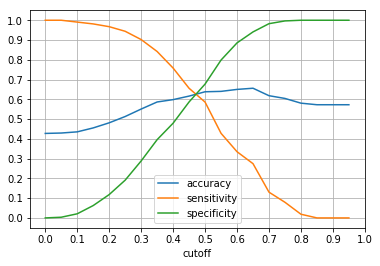

In [35]:
find_ideal_cutoff()

In [36]:
prob_cut_off=0.5
print ('Train Metrics \n')
validate_model(X_train,y_train,prob_cut_off,print_flag=True)
print ('\nTest Metrics \n')
X_test=X_test[X_train.columns]
validate_model(X_test,y_test,prob_cut_off,print_flag=True)


Train Metrics 

Accuracy :  0.638171
Sensitivity :  0.586047
Specificity :  0.677083

Test Metrics 

Accuracy :  0.65873
Sensitivity :  0.6
Specificity :  0.721311


(0.65873, 0.6, 0.721311)

## Predict for upcoming League Matches

#### functionto decide the winner

In [37]:
def decide_winner(x):
    if x.Team1_Winner == 1 :
        x.Winner=x.Team1
    else:
        x.Winner=x.Team2
    x= caclulate_match_points(x)
    return x

## Rankings before upcoming League Matches

In [38]:
def get_ranks():
    df_ranks1=df_cur_matches[['Team1','Team1_points_after']]
    df_ranks1=df_ranks1.rename(columns=({'Team1':'Team','Team1_points_after':'Points'}))
    df_ranks2=df_cur_matches[['Team2','Team2_points_after']]
    df_ranks2=df_ranks2.rename(columns=({'Team2':'Team','Team2_points_after':'Points'}))
    df_ranks=pd.concat([df_ranks1,df_ranks2],axis=0)
    df_ranks=df_ranks.reset_index()

    df_ranks=df_ranks.loc[df_ranks.groupby(['Team'])['Points'].idxmax()]
    df_ranks = df_ranks.sort_values(by='Points',ascending=False).reset_index()
    df_ranks['Rank']=df_ranks.index+1
#     print(df_ranks)
    return df_ranks

In [39]:
df_cur_matches = df_matches_points.loc[df_matches_points.Season=='Season 7']
df_cur_matches=set_team_standing_points(df_cur_matches)
ranks=get_ranks()
ranks[['Team','Points','Rank']]

,Team,Points,Rank
0,Dabang Delhi K.C.,82.0,1
1,Bengal Warriors,73.0,2
2,Haryana Steelers,65.0,3
3,Bengaluru Bulls,58.0,4
4,U.P. Yoddha,58.0,5
5,U Mumba,54.0,6
6,Jaipur Pink Panthers,52.0,7
7,Gujarat Fortunegiants,45.0,8
8,Puneri Paltan,42.0,9
9,Patna Pirates,40.0,10


In [40]:
# Scale upcoming matches data
X_upcoming=df_matches_upcoming[input_cols_to_model]
X_upcoming[cols_to_scale]=scaler.transform(X_upcoming[cols_to_scale])

model_columns=X_train.columns
X_upcoming = X_upcoming[model_columns]
y_upcoming_pred = round(logmodel.predict(X_upcoming), 6)

df_up=pd.DataFrame(columns=['y_prob'],data=y_upcoming_pred)
df_matches_upcoming_pred=pd.concat([df_matches_upcoming,df_up],axis=1)

df_matches_upcoming_pred['Team1_Winner']=df_matches_upcoming_pred['y_prob'].apply(lambda x: 1 if x >prob_cut_off else 0 )

df_matches_upcoming_pred=df_matches_upcoming_pred.apply(decide_winner, axis=1)
df_matches_upcoming_pred.drop('y_prob',axis=1)

df_matches_upcoming_pred[['Date','Team1','Team2','Winner','Team1_Winner']]

,Date,Team1,Team2,Winner,Team1_Winner
629,2019-09-30,Bengal Warriors,Dabang Delhi K.C.,Bengal Warriors,1
630,2019-09-30,Tamil Thalaivas,U Mumba,U Mumba,0
631,2019-10-02,U Mumba,Patna Pirates,Patna Pirates,0
632,2019-10-02,Haryana Steelers,Bengaluru Bulls,Bengaluru Bulls,0
633,2019-10-03,Telugu Titans,Puneri Paltan,Puneri Paltan,0
634,2019-10-04,Jaipur Pink Panthers,Bengaluru Bulls,Jaipur Pink Panthers,1
635,2019-10-04,Haryana Steelers,Telugu Titans,Haryana Steelers,1
636,2019-10-05,U.P. Yoddha,Dabang Delhi K.C.,Dabang Delhi K.C.,0
637,2019-10-05,Gujarat Fortunegiants,Patna Pirates,Patna Pirates,0
638,2019-10-06,Bengal Warriors,Patna Pirates,Bengal Warriors,1


## Rankings after all League Matches

In [41]:
df_cur_matches=pd.concat([df_cur_matches,df_matches_upcoming_pred])
df_cur_matches=set_team_standing_points(df_cur_matches)
df_ranks=get_ranks()
df_ranks[['Team','Points','Rank']]

,Team,Points,Rank
0,Dabang Delhi K.C.,92.0,1
1,Bengal Warriors,88.0,2
2,Haryana Steelers,75.0,3
3,Bengaluru Bulls,68.0,4
4,Jaipur Pink Panthers,62.0,5
5,U Mumba,59.0,6
6,U.P. Yoddha,58.0,7
7,Puneri Paltan,52.0,8
8,Gujarat Fortunegiants,50.0,9
9,Patna Pirates,50.0,10


## Scores after all league matches

In [42]:
def get_scores(team):
    return df_cur_matches[df_cur_matches.Team1 == team][['Team1',
                                                         'Team1_Successful_Raids', 'Team1_Successful_Tackles',
                                                         'Team1_Super_Raid', 'Team1_Super_Tackles',
                                                         'Team1_All_outs_Inflicted', 'Team1_All_outs_Conceded']].head(1)

In [43]:
teams = sorted(list(df_cur_matches.Team1.unique()))

df_scores = pd.DataFrame()

for team in teams:
    df_scores = pd.concat([df_scores, get_scores(team)], axis=0)

df_scores.columns = ['Team', 'Raids', 'Tackles', 'Super_Raids', 'Super_Tackles', 'All_outs_Inflicted', 'All_outs_Conceded']
df_scores = df_scores.reset_index(drop=True)
df_scores['SPT'] = df_scores.Super_Raids + df_scores.Super_Tackles + df_scores.All_outs_Inflicted - df_scores.All_outs_Conceded
df_scores = df_scores.drop(columns=['Super_Raids', 'Super_Tackles', 'All_outs_Inflicted', 'All_outs_Conceded'], axis=1)
df_scores['Matches_Played'] = 11
df_scores['Avg_Raids'] = df_scores.Raids / 11
df_scores['Avg_Tackles'] = df_scores.Tackles / 11
df_scores['Avg_SPT'] = df_scores.SPT / 11
df_scores

,Team,Raids,Tackles,SPT,Matches_Played,Avg_Raids,Avg_Tackles,Avg_SPT
0,Bengal Warriors,318.0,174.0,42.0,11,28.909091,15.818182,3.818182
1,Bengaluru Bulls,309.0,168.0,30.0,11,28.090909,15.272727,2.727273
2,Dabang Delhi K.C.,340.0,175.0,34.0,11,30.909091,15.909091,3.090909
3,Gujarat Fortunegiants,265.0,187.0,21.0,11,24.090909,17.000000,1.909091
4,Haryana Steelers,290.0,181.0,34.0,11,26.363636,16.454545,3.090909
5,Jaipur Pink Panthers,261.0,189.0,35.0,11,23.727273,17.181818,3.181818
6,Patna Pirates,291.0,168.0,41.0,11,26.454545,15.272727,3.727273
7,Puneri Paltan,290.0,207.0,16.0,11,26.363636,18.818182,1.454545
8,Tamil Thalaivas,259.0,151.0,1.0,11,23.545455,13.727273,0.090909
9,Telugu Titans,273.0,162.0,21.0,11,24.818182,14.727273,1.909091


In [44]:
def increment_scores(team):
    for row in range(0, len(df_scores)):
        if df_scores.iloc[row]['Team'] == team:
            df_scores.loc[row, 'Matches_Played'] += 1
            df_scores.loc[row, 'Raids'] += df_scores.loc[row, 'Avg_Raids']
            df_scores.loc[row, 'Tackles'] += df_scores.loc[row, 'Avg_Tackles']
            df_scores.loc[row, 'SPT'] += df_scores.loc[row, 'Avg_SPT']        

## Predicting Elimination Matches

#### set teams 3 vs 6 and 4 vs 5

In [45]:
df_finals.loc[df_finals.Match_Type=='E1','Team1']=df_ranks.loc[df_ranks.Rank==3,'Team'].iloc[0]
df_finals.loc[df_finals.Match_Type=='E1','Team2']=df_ranks.loc[df_ranks.Rank==6,'Team'].iloc[0]
df_finals.loc[df_finals.Match_Type=='E2','Team1']=df_ranks.loc[df_ranks.Rank==4,'Team'].iloc[0]
df_finals.loc[df_finals.Match_Type=='E2','Team2']=df_ranks.loc[df_ranks.Rank==5,'Team'].iloc[0]

In [46]:
def predict_final_matches(match_type):
    global df_cur_matches
    if match_type=='EL' :
        Match_Nos=['E1','E2']
    elif match_type=='SF' :
        Match_Nos=['SF1','SF2']
    elif match_type=='F' :
        Match_Nos=['F']
    
    df_cur_matches=df_cur_matches[~df_cur_matches.Match_Type.isin(Match_Nos)]
    
    df_to_pred=df_finals.loc[df_finals.Match_No.isin(Match_Nos)]
    df_to_pred

    match_rows=[]
    for rownum in range(df_to_pred.shape[0]):
        row = get_season_points(df_to_pred.iloc[rownum]) 
        match_rows.append(row)
    df_final_matches = pd.DataFrame(data=match_rows) 
    df_final_matches=df_final_matches.set_index('Match_Number', drop=False)
    df_final_matches=df_final_matches.drop('index',axis=1)

    df_cur_matches=pd.concat([df_cur_matches,df_final_matches],axis=0)
    df_cur_matches=df_cur_matches.set_index('Match_Number', drop=False)

    df_cur_matches=set_team_standing_points(df_cur_matches)

    df_final_matches=df_cur_matches.loc[df_cur_matches.Match_Type.isin(Match_Nos)]

    df_final_matches=df_final_matches.drop('y_prob',axis=1)

    X_final=df_final_matches[input_cols_to_model]
    X_final[cols_to_scale]=scaler.transform(X_final[cols_to_scale])

    X_final = X_final[model_columns]
    y_final = round(logmodel.predict(X_final), 6)

    df_final=pd.DataFrame(columns=['y_prob'],data=y_final)
    df_final_matches=pd.concat([df_final_matches,df_final],axis=1)

    df_final_matches['Team1_Winner']=df_final_matches['y_prob'].apply(lambda x: 1 if x >prob_cut_off else 0 )

    df_final_matches=df_final_matches.apply(decide_winner, axis=1)
    df_final_matches.drop('y_prob',axis=1)
    
    df_cur_matches=df_cur_matches[~df_cur_matches.Match_Type.isin(Match_Nos)]
    df_cur_matches=pd.concat([df_cur_matches,df_final_matches])
    df_cur_matches=set_team_standing_points(df_cur_matches)

    return df_final_matches

In [47]:
df_el_matches = predict_final_matches('EL')
df_el_matches[['Date','Match_No','Team1','Team2','Winner','Team1_Winner']]

,Date,Match_No,Team1,Team2,Winner,Team1_Winner
Match_Number,,,,,,
648,2019-10-14,E1,Haryana Steelers,U Mumba,Haryana Steelers,1
649,2019-10-14,E2,Bengaluru Bulls,Jaipur Pink Panthers,Bengaluru Bulls,1


In [48]:
increment_scores(df_el_matches['Team1'].values[0])
increment_scores(df_el_matches['Team1'].values[1])
increment_scores(df_el_matches['Team2'].values[0])
increment_scores(df_el_matches['Team2'].values[1])

In [49]:
df_scores

,Team,Raids,Tackles,SPT,Matches_Played,Avg_Raids,Avg_Tackles,Avg_SPT
0,Bengal Warriors,318.000000,174.000000,42.000000,11,28.909091,15.818182,3.818182
1,Bengaluru Bulls,337.090909,183.272727,32.727273,12,28.090909,15.272727,2.727273
2,Dabang Delhi K.C.,340.000000,175.000000,34.000000,11,30.909091,15.909091,3.090909
3,Gujarat Fortunegiants,265.000000,187.000000,21.000000,11,24.090909,17.000000,1.909091
4,Haryana Steelers,316.363636,197.454545,37.090909,12,26.363636,16.454545,3.090909
5,Jaipur Pink Panthers,284.727273,206.181818,38.181818,12,23.727273,17.181818,3.181818
6,Patna Pirates,291.000000,168.000000,41.000000,11,26.454545,15.272727,3.727273
7,Puneri Paltan,290.000000,207.000000,16.000000,11,26.363636,18.818182,1.454545
8,Tamil Thalaivas,259.000000,151.000000,1.000000,11,23.545455,13.727273,0.090909
9,Telugu Titans,273.000000,162.000000,21.000000,11,24.818182,14.727273,1.909091


### Predict Semi Finals

In [50]:
df_finals.loc[df_finals.Match_No=='SF1','Team1']=df_ranks.loc[df_ranks.Rank==1,'Team'].iloc[0]
df_finals.loc[df_finals.Match_No=='SF1','Team2']=df_cur_matches.loc[df_cur_matches.Match_Type=='E1','Winner'].iloc[0]
df_finals.loc[df_finals.Match_No=='SF2','Team1']=df_ranks.loc[df_ranks.Rank==2,'Team'].iloc[0]
df_finals.loc[df_finals.Match_No=='SF2','Team2']=df_cur_matches.loc[df_cur_matches.Match_Type=='E2','Winner'].iloc[0]

In [51]:
df_sf_matches = predict_final_matches('SF')
df_sf_matches[['Date','Match_No','Team1','Team2','Winner','Team1_Winner']]

,Date,Match_No,Team1,Team2,Winner,Team1_Winner
Match_Number,,,,,,
650,2019-10-16,SF1,Dabang Delhi K.C.,Haryana Steelers,Dabang Delhi K.C.,1
651,2019-10-16,SF2,Bengal Warriors,Bengaluru Bulls,Bengal Warriors,1


In [52]:
increment_scores(df_sf_matches['Team1'].values[0])
increment_scores(df_sf_matches['Team1'].values[1])
increment_scores(df_sf_matches['Team2'].values[0])
increment_scores(df_sf_matches['Team2'].values[1])

In [53]:
df_scores

,Team,Raids,Tackles,SPT,Matches_Played,Avg_Raids,Avg_Tackles,Avg_SPT
0,Bengal Warriors,346.909091,189.818182,45.818182,12,28.909091,15.818182,3.818182
1,Bengaluru Bulls,365.181818,198.545455,35.454545,13,28.090909,15.272727,2.727273
2,Dabang Delhi K.C.,370.909091,190.909091,37.090909,12,30.909091,15.909091,3.090909
3,Gujarat Fortunegiants,265.000000,187.000000,21.000000,11,24.090909,17.000000,1.909091
4,Haryana Steelers,342.727273,213.909091,40.181818,13,26.363636,16.454545,3.090909
5,Jaipur Pink Panthers,284.727273,206.181818,38.181818,12,23.727273,17.181818,3.181818
6,Patna Pirates,291.000000,168.000000,41.000000,11,26.454545,15.272727,3.727273
7,Puneri Paltan,290.000000,207.000000,16.000000,11,26.363636,18.818182,1.454545
8,Tamil Thalaivas,259.000000,151.000000,1.000000,11,23.545455,13.727273,0.090909
9,Telugu Titans,273.000000,162.000000,21.000000,11,24.818182,14.727273,1.909091


### Predicting Finals

In [54]:
df_finals.loc[df_finals.Match_No=='F','Team1']=df_cur_matches.loc[df_cur_matches.Match_Type=='SF1','Winner'].iloc[0]
df_finals.loc[df_finals.Match_No=='F','Team2']=df_cur_matches.loc[df_cur_matches.Match_Type=='SF2','Winner'].iloc[0]

In [55]:
df_final_matches = predict_final_matches('F')
df_final_matches[['Date','Match_No','Team1','Team2','Winner','Team1_Winner']]

,Date,Match_No,Team1,Team2,Winner,Team1_Winner
Match_Number,,,,,,
652,2019-10-19,F,Dabang Delhi K.C.,Bengal Warriors,Dabang Delhi K.C.,1


In [56]:
increment_scores(df_final_matches['Team1'].values[0])
increment_scores(df_final_matches['Team2'].values[0])

In [57]:
df_scores

,Team,Raids,Tackles,SPT,Matches_Played,Avg_Raids,Avg_Tackles,Avg_SPT
0,Bengal Warriors,375.818182,205.636364,49.636364,13,28.909091,15.818182,3.818182
1,Bengaluru Bulls,365.181818,198.545455,35.454545,13,28.090909,15.272727,2.727273
2,Dabang Delhi K.C.,401.818182,206.818182,40.181818,13,30.909091,15.909091,3.090909
3,Gujarat Fortunegiants,265.000000,187.000000,21.000000,11,24.090909,17.000000,1.909091
4,Haryana Steelers,342.727273,213.909091,40.181818,13,26.363636,16.454545,3.090909
5,Jaipur Pink Panthers,284.727273,206.181818,38.181818,12,23.727273,17.181818,3.181818
6,Patna Pirates,291.000000,168.000000,41.000000,11,26.454545,15.272727,3.727273
7,Puneri Paltan,290.000000,207.000000,16.000000,11,26.363636,18.818182,1.454545
8,Tamil Thalaivas,259.000000,151.000000,1.000000,11,23.545455,13.727273,0.090909
9,Telugu Titans,273.000000,162.000000,21.000000,11,24.818182,14.727273,1.909091


### Final Teams Ranks

In [58]:
df_ranks = get_ranks()
df_ranks[['Team','Points','Rank']]

,Team,Points,Rank
0,Dabang Delhi K.C.,102.0,1
1,Bengal Warriors,93.0,2
2,Haryana Steelers,80.0,3
3,Bengaluru Bulls,73.0,4
4,Jaipur Pink Panthers,62.0,5
5,U Mumba,59.0,6
6,U.P. Yoddha,58.0,7
7,Puneri Paltan,52.0,8
8,Gujarat Fortunegiants,50.0,9
9,Patna Pirates,50.0,10


## Season Winners

In [59]:
fin_matches=df_cur_matches.loc[df_cur_matches.Match_Type.isin(['E1','E2','SF1','SF2','F'])]
fin_matches[['Date','Match_Type','Team1','Team2','Winner','Team1_Winner']].sort_values(by='Date',ascending=False)

,Date,Match_Type,Team1,Team2,Winner,Team1_Winner
Match_Number,,,,,,
652,2019-10-19,F,Dabang Delhi K.C.,Bengal Warriors,Dabang Delhi K.C.,1
650,2019-10-16,SF1,Dabang Delhi K.C.,Haryana Steelers,Dabang Delhi K.C.,1
651,2019-10-16,SF2,Bengal Warriors,Bengaluru Bulls,Bengal Warriors,1
648,2019-10-14,E1,Haryana Steelers,U Mumba,Haryana Steelers,1
649,2019-10-14,E2,Bengaluru Bulls,Jaipur Pink Panthers,Bengaluru Bulls,1


## Winner of the tournament

In [60]:
for index, row in fin_matches.iterrows():
    if row.Match_Type == 'F':
        if row.Team1_Winner == 1:
            print(row.Team1)
        else:
            print(row.Team2)

Dabang Delhi K.C.


## Top team after league matches

In [61]:
df_ranks[df_ranks.Rank == 1]

,index,Match_Number,Team,Points,Rank
0,136,652,Dabang Delhi K.C.,102.0,1


## Highest Successful Raids

In [62]:
df_scores[df_scores.Raids == df_scores.Raids.max()]

,Team,Raids,Tackles,SPT,Matches_Played,Avg_Raids,Avg_Tackles,Avg_SPT
2,Dabang Delhi K.C.,401.818182,206.818182,40.181818,13,30.909091,15.909091,3.090909


## Highest Successful Tackles

In [63]:
df_scores[df_scores.Tackles == df_scores.Tackles.max()]

,Team,Raids,Tackles,SPT,Matches_Played,Avg_Raids,Avg_Tackles,Avg_SPT
4,Haryana Steelers,342.727273,213.909091,40.181818,13,26.363636,16.454545,3.090909


## Highest Successful Super-performance Total

In [64]:
df_scores[df_scores.SPT == df_scores.SPT.max()]

,Team,Raids,Tackles,SPT,Matches_Played,Avg_Raids,Avg_Tackles,Avg_SPT
0,Bengal Warriors,375.818182,205.636364,49.636364,13,28.909091,15.818182,3.818182
